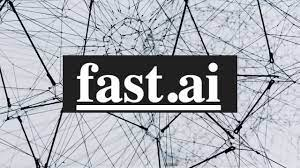

In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [ ]:
!tree ../input/ -d

In [ ]:
DATA_DIR = Path('../input/cassava-leaf-disease-classification')
TRAIN_DIR = DATA_DIR/'train_images'
TEST_DIR = DATA_DIR/'test_images'
train_csv_path = Path('../input/cassava-leaf-disease-classification/train.csv')
train_df = pd.read_csv(train_csv_path)

In [ ]:
def get_y(path):
    fname = path.name
    return train_df.query("image_id==@fname").label.values[-1]

In [ ]:
cassava_data = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                        get_items = get_image_files, 
                        splitter = RandomSplitter(seed=42),
                        get_y = get_y, 
                        item_tfms = Resize(460),
                        batch_tfms = [*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

dls = cassava_data.dataloaders(TRAIN_DIR, batch_size=32)

In [ ]:
dls.show_batch()

In [ ]:
len(dls.train.dataset), len(dls.valid.dataset)

In [ ]:
cassava_learn = cnn_learner(dls, resnet18, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp(0.4))

In [ ]:
cassava_learn.unfreeze()
cassava_learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp(0.4), model_dir='/tmp/models').to_fp16()
learn.unfreeze()
learn.fit_one_cycle(5, lr_max = 1e-3)

In [ ]:
sample_df = pd.read_csv(DATA_DIR/'sample_submission.csv')
sample_df.head()

In [ ]:
test_data_path = sample_df['image_id'].apply(lambda x: DATA_DIR/'test_images'/x)
tst_dl = learn.dls.test_dl(test_data_path)

In [ ]:
predictions = learn.tta(dl = tst_dl, n=10, beta=0)

sample_df['label'] = np.argmax(predictions[0],axis=1)
sample_df

# Please Upvote if you liked the work. Thanks :)